<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="text-align: left;">
        <p style="color:#FFD700; font-size: 15px; font-weight: bold; margin-bottom: 1px; text-align: left;">Published on  January 05, 2026</p>
        <h4 style="color:#4B0082; font-weight: bold; text-align: left; margin-top: 6px;">Author: Jocelyn C. Dumlao</h4>
        <p style="font-size: 17px; line-height: 1.7; color: #333; text-align: center; margin-top: 20px;"></p>
        <a href="https://www.linkedin.com/in/jocelyn-dumlao-168921a8/" target="_blank" style="display: inline-block; background-color: #003f88; color: #fff; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px;">LinkedIn</a>
        <a href="https://github.com/jcdumlao14" target="_blank" style="display: inline-block; background-color: transparent; color: #059c99; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px; border: 2px solid #007bff;">GitHub</a>
        <a href="https://www.youtube.com/@CogniCraftedMinds" target="_blank" style="display: inline-block; background-color: #ff0054; color: #fff; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px;">YouTube</a>
        <a href="https://www.kaggle.com/jocelyndumlao" target="_blank" style="display: inline-block; background-color: #3a86ff; color: #fff; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px;">Kaggle</a>
    </div>
</div>

# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>IMPORTS & SETTINGS</p></div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

from category_encoders import TargetEncoder
import xgboost as xgb

warnings.filterwarnings("ignore")
np.random.seed(42)

sns.set_theme(style="white")
plt.rcParams['axes.grid'] = False


In [2]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U category_encoders

In [4]:
pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install --upgrade scikit-learn

# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>HELPER</p></div>

In [6]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>DATA LOADING</p></div>

In [7]:
# DATA LOADING

def load_data():
    path = "/kaggle/input/"
    train = pd.read_csv(f"{path}playground-series-s6e1/train.csv")
    test = pd.read_csv(f"{path}playground-series-s6e1/test.csv")
    orig = pd.read_csv(f"{path}exam-score-prediction-dataset/Exam_Score_Prediction.csv")
    sub = pd.read_csv(f"{path}playground-series-s6e1/sample_submission.csv")
    return train, test, orig, sub

train_df, test_df, original_df, submission_df = load_data()


In [8]:
train_df.head().style.background_gradient(cmap='gist_rainbow')

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.910000,98.800000,no,4.900000,average,online videos,low,easy,78.300000
1,1,18,other,diploma,4.950000,94.800000,yes,4.700000,poor,self-study,medium,moderate,46.700000
2,2,20,female,b.sc,4.680000,92.600000,yes,5.800000,poor,coaching,high,moderate,99.000000
3,3,19,male,b.sc,2.000000,49.500000,yes,8.300000,average,group study,high,moderate,63.900000
4,4,23,male,bca,7.650000,86.900000,yes,9.600000,good,self-study,high,easy,100.000000


In [9]:
test_df.head().style.background_gradient(cmap='gist_rainbow')

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.850000,65.200000,yes,5.200000,poor,group study,high,easy
1,630001,18,male,diploma,6.610000,45.000000,no,9.300000,poor,coaching,low,easy
2,630002,24,female,b.tech,6.600000,98.500000,yes,6.200000,good,group study,medium,moderate
3,630003,24,male,diploma,3.030000,66.300000,yes,5.700000,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.030000,42.400000,yes,9.200000,average,coaching,low,moderate


In [10]:
original_df.head().style.background_gradient(cmap='gist_rainbow')

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.780000,92.900000,yes,7.400000,poor,coaching,low,hard,58.900000
1,2,23,other,bca,3.370000,64.800000,yes,4.600000,average,online videos,medium,moderate,54.800000
2,3,22,male,b.sc,7.880000,76.800000,yes,8.500000,poor,coaching,high,moderate,90.300000
3,4,20,other,diploma,0.670000,48.400000,yes,5.800000,average,online videos,low,moderate,29.700000
4,5,20,female,diploma,0.890000,71.600000,yes,9.800000,poor,coaching,low,moderate,43.700000


In [11]:
print("\nSummary statistics of numerical columns:")
train_df.describe().style.background_gradient(cmap='tab20c')


Summary statistics of numerical columns:


,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


In [12]:
print("\nNumber of missing values in each column:")
train_df.isnull().sum().sort_values(ascending=False)


Number of missing values in each column:


id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>EDA</p></div>

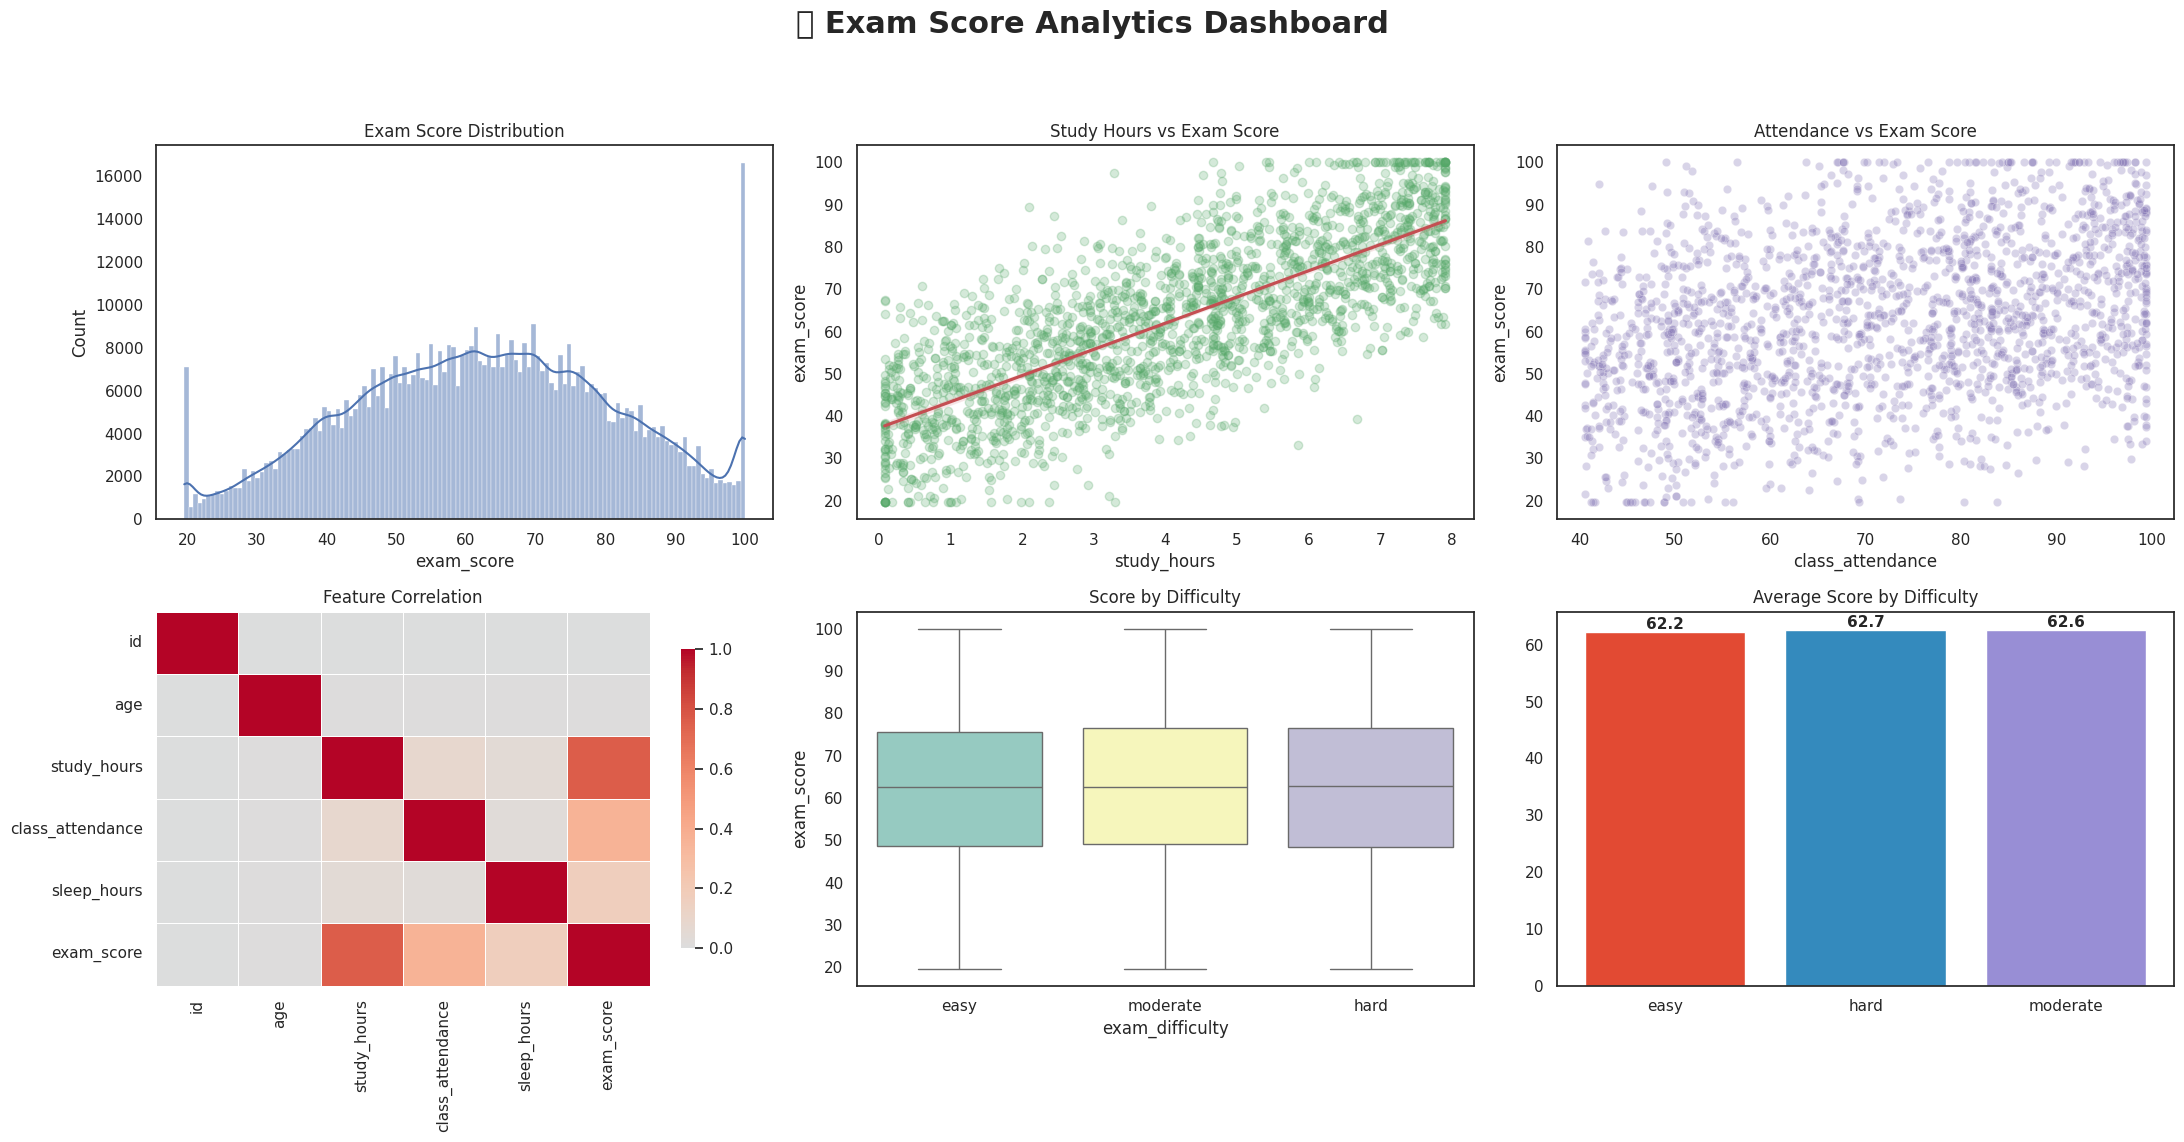

In [13]:
# EDA 
def perform_eda(df):
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    fig.suptitle("📊 Exam Score Analytics Dashboard", fontsize=22, fontweight="bold")

    sns.histplot(df['exam_score'], kde=True, color="#4C72B0", ax=axes[0, 0])
    axes[0, 0].set_title("Exam Score Distribution")

    sns.regplot(
        data=df.sample(min(2000, len(df))),
        x='study_hours',
        y='exam_score',
        scatter_kws={'alpha': 0.25, 'color': "#55A868"},
        line_kws={'color': "#C44E52"},
        ax=axes[0, 1]
    )
    axes[0, 1].set_title("Study Hours vs Exam Score")

    sns.scatterplot(
        data=df.sample(min(2000, len(df))),
        x='class_attendance',
        y='exam_score',
        alpha=0.3,
        color="#8172B3",
        ax=axes[0, 2]
    )
    axes[0, 2].set_title("Attendance vs Exam Score")

    corr = df.select_dtypes(include=np.number).corr()
    sns.heatmap(
        corr, cmap="coolwarm", center=0,
        linewidths=0.5, cbar_kws={'shrink': 0.8},
        ax=axes[1, 0]
    )
    axes[1, 0].set_title("Feature Correlation")

    sns.boxplot(
        data=df, x="exam_difficulty", y="exam_score",
        palette="Set3", ax=axes[1, 1]
    )
    axes[1, 1].set_title("Score by Difficulty")

    mean_scores = df.groupby("exam_difficulty")["exam_score"].mean()
    bars = axes[1, 2].bar(
        mean_scores.index,
        mean_scores.values,
        color=["#E24A33", "#348ABD", "#988ED5"]
    )
    axes[1, 2].set_title("Average Score by Difficulty")

    for bar in bars:
        axes[1, 2].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f"{bar.get_height():.1f}",
            ha="center", fontsize=11, fontweight="bold"
        )

    for ax in axes.flat:
        ax.grid(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.show()

perform_eda(train_df)

# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>FEATURE ENGINEERING</p></div>

In [14]:
# FEATURE ENGINEERING

def engineer_features(df):
    df = df.copy()

    df['study_efficiency'] = df['study_hours'] / (df['sleep_hours'] + 1)
    df['attendance_rate_sq'] = df['class_attendance'] ** 2
    df['log_study'] = np.log1p(df['study_hours'])

    mapping = {
        'sleep_quality': {'poor': 0, 'average': 1, 'good': 2},
        'facility_rating': {'low': 0, 'medium': 1, 'high': 2},
        'exam_difficulty': {'easy': 0, 'medium': 1, 'hard': 2}
    }

    for col, m in mapping.items():
        if col in df.columns:
            df[f'{col}_num'] = df[col].map(m).fillna(1)

    # avoid KeyError if exam_difficulty_num missing
    if 'exam_difficulty_num' in df.columns:
        df['stress_factor'] = df['exam_difficulty_num'] / (df['sleep_hours'] + 1)
    else:
        df['stress_factor'] = 0

    return df


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>DATA PREP</p></div>

In [15]:
# DATA PREP

TARGET = "exam_score"

X = engineer_features(train_df).drop(['id', TARGET], axis=1)
y = train_df[TARGET]

X_test = engineer_features(test_df).drop(['id'], axis=1)
X_orig = engineer_features(original_df).drop([TARGET], axis=1)
y_orig = original_df[TARGET]

# 🔧 CRITICAL FIX 1: align columns
X_test = X_test[X.columns]
X_orig = X_orig[X.columns]

# 🔧 CRITICAL FIX 2: encode ALL categorical columns
CATS = X.select_dtypes(include=['object']).columns.tolist()


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>STAGE 1 – RIDGE </p></div>

In [16]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_ridge = np.zeros(len(X))
test_preds_ridge = np.zeros(len(X_test))
orig_preds_ridge = np.zeros(len(X_orig))

print("🚀 Starting Stage 1: Ridge Linear Stacking...")

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    X_tr_ext = pd.concat([X_tr, X_orig], axis=0)
    y_tr_ext = pd.concat([y_tr, y_orig], axis=0)

    te = TargetEncoder(cols=CATS)
    X_tr_enc = te.fit_transform(X_tr_ext, y_tr_ext)
    X_val_enc = te.transform(X_val)
    X_test_enc = te.transform(X_test)
    X_orig_enc = te.transform(X_orig)

    ridge = RidgeCV(alphas=np.logspace(-2, 4, 10))
    ridge.fit(X_tr_enc, y_tr_ext)

    oof_ridge[val_idx] = ridge.predict(X_val_enc)
    test_preds_ridge += ridge.predict(X_test_enc) / FOLDS
    orig_preds_ridge += ridge.predict(X_orig_enc) / FOLDS

print(f"✅ Ridge OOF RMSE: {calculate_rmse(y, oof_ridge):.5f}")

🚀 Starting Stage 1: Ridge Linear Stacking...
✅ Ridge OOF RMSE: 8.90635


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>STAGE 2 – XGBOOST</p></div>

In [17]:
# STAGE 2 – XGBOOST

X['ridge_pred'] = oof_ridge
X_test['ridge_pred'] = test_preds_ridge
X_orig['ridge_pred'] = orig_preds_ridge

for col in CATS:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_orig[col] = X_orig[col].astype('category')

xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'enable_categorical': True,
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50
}

oof_xgb = np.zeros(len(X))
final_preds = np.zeros(len(X_test))

print("\n🔥 Starting Stage 2: XGBoost Refinement...")

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    X_tr_ext = pd.concat([X_tr, X_orig], axis=0)
    y_tr_ext = pd.concat([y_tr, y_orig], axis=0)

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_tr_ext, y_tr_ext, eval_set=[(X_val, y_val)], verbose=False)

    oof_xgb[val_idx] = model.predict(X_val)
    final_preds += model.predict(X_test) / FOLDS

print(f"🏆 Final Ensemble OOF RMSE: {calculate_rmse(y, oof_xgb):.5f}")



🔥 Starting Stage 2: XGBoost Refinement...
🏆 Final Ensemble OOF RMSE: 8.74181


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#2648aa ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #f4db32;"><b> </b>SUBMISSION</p></div>

In [18]:
# SUBMISSION

submission_df[TARGET] = final_preds
submission_df.to_csv("submission.csv", index=False)
print("📁 submission.csv saved successfully!")

📁 submission.csv saved successfully!
